In [125]:
! uv pip install numpy pandas wfdb matplotlib ecgmentations pytorch_metric_learning --quiet

In [126]:
import torch
torch.cuda.is_available(), torch.cuda.is_bf16_supported()

(True, True)

In [127]:
import ast

import numpy as np
import pandas as pd
import wfdb


def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path + "/" + f) for f in df.filename_lr[:4000]]
    else:
        data = [wfdb.rdsamp(path + "/" + f) for f in df.filename_hr[:4000]]
    data = np.array([signal for signal, meta in data])
    return data


path = "/home/aimakeradmin/shady/Self-Supervied-Contrastive-Representation-Learning-ECG-Signals/data/raw/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1"
sampling_rate = 500

# load and convert annotation data
Y = pd.read_csv(path + "/ptbxl_database.csv", index_col="ecg_id")[:4000]
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path + "/scp_statements.csv", index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]


def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))


# Apply diagnostic superclass
Y["diagnostic_superclass"] = Y.scp_codes.apply(aggregate_diagnostic)

# Split data into train, validation, and test
test_fold = 10
val_fold = 9
# Train
X_train = X[np.where((Y.strat_fold != test_fold) & (Y.strat_fold != val_fold))]
y_train = Y[(Y.strat_fold != test_fold) & (Y.strat_fold != val_fold)].diagnostic_superclass
# Validation
X_val = X[np.where(Y.strat_fold == val_fold)]
y_val = Y[Y.strat_fold == val_fold].diagnostic_superclass
# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass


In [128]:
X_val.shape, X_test.shape, X_train.shape

((502, 5000, 12), (520, 5000, 12), (2978, 5000, 12))

# Data Augmenter and Dataset Classes

## Dual Augmenter Class

Custom augmentation class that ensures two augmented views are not identical.

In [129]:
import numpy as np
import random
import warnings
from scipy.spatial.distance import cosine
from typing import List, Callable, Tuple


class DualAugmenter:
    """
    Custom augmenter that produces two guaranteed-different augmented views.
    
    Ensures augmentation diversity through similarity checks with a retry mechanism.
    Enforces both minimum and maximum similarity to ensure positive pairs are
    similar enough to be meaningful but different enough to learn from.
    
    Args:
        augmentation_pool: List of augmentation functions to sample from
        min_similarity: Minimum cosine similarity allowed (default 0.5)
        max_similarity: Maximum cosine similarity allowed (default 0.995)
        max_retries: Maximum attempts to generate diverse pair (default 10)
    """
    
    def __init__(
        self,
        augmentation_pool: List[Callable],
        min_similarity: float = 0.5,
        max_similarity: float = 0.95,
        max_retries: int = 10,
    ):
        self.augmentation_pool = augmentation_pool
        self.min_similarity = min_similarity
        self.max_similarity = max_similarity
        self.max_retries = max_retries
        
        if min_similarity >= max_similarity:
            raise ValueError(f"min_similarity ({min_similarity}) must be less than max_similarity ({max_similarity})")
    
    def _calculate_similarity(self, aug1: np.ndarray, aug2: np.ndarray) -> float:
        """Calculate cosine similarity between two augmented signals."""
        return 1 - cosine(aug1.flatten(), aug2.flatten())
    
    def _are_identical(self, aug1: np.ndarray, aug2: np.ndarray) -> bool:
        """Quick check if augmentations are bit-for-bit identical."""
        return np.array_equal(aug1, aug2)
    
    def _sample_augmentation(self) -> Callable:
        """Randomly sample an augmentation from the pool."""
        return random.sample(self.augmentation_pool, k=1)[0]
    
    def __call__(self, ecg: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        Generate two diverse augmented views of the input signal.
        
        Args:
            ecg: Input ECG signal of shape (time_steps, num_channels)
            
        Returns:
            Tuple of (aug1, aug2) - two augmented views with similarity in valid range
        """
        best_aug1, best_aug2 = None, None
        best_similarity = 1.0
        best_distance_from_range = float('inf')
        
        for attempt in range(self.max_retries):
            # Sample two augmentations
            augmenter1 = self._sample_augmentation()
            augmenter2 = self._sample_augmentation()
            
            # Apply augmentations
            aug1 = augmenter1(ecg=ecg)["ecg"]
            aug2 = augmenter2(ecg=ecg)["ecg"]
            
            # Quick check: are they identical?
            if self._are_identical(aug1, aug2):
                continue
            
            # Check similarity
            similarity = self._calculate_similarity(aug1, aug2)
            
            # Calculate distance from valid range
            if similarity < self.min_similarity:
                distance_from_range = self.min_similarity - similarity
            elif similarity > self.max_similarity:
                distance_from_range = similarity - self.max_similarity
            else:
                distance_from_range = 0.0
            
            # Track best attempt (closest to valid range)
            if distance_from_range < best_distance_from_range:
                best_distance_from_range = distance_from_range
                best_similarity = similarity
                best_aug1, best_aug2 = aug1, aug2
            
            # Success: found pair within valid similarity range
            if self.min_similarity <= similarity <= self.max_similarity:
                return aug1, aug2
        
        # Max retries reached - return best attempt with warning
        if best_distance_from_range > 0:
            if best_similarity < self.min_similarity:
                warnings.warn(
                    f"Max retries ({self.max_retries}) reached. "
                    f"Best similarity: {best_similarity:.4f} < min threshold: {self.min_similarity}"
                )
            else:
                warnings.warn(
                    f"Max retries ({self.max_retries}) reached. "
                    f"Best similarity: {best_similarity:.4f} > max threshold: {self.max_similarity}"
                )
        
        return best_aug1, best_aug2

In [130]:
from typing import Optional, Tuple

import numpy as np
import torch


class ECGContrastiveTrainDataset(torch.utils.data.Dataset):
    """
    Updated ECG dataset for contrastive learning using DualAugmenter.
    
    This ensures that the two augmented views are guaranteed to be different,
    which is crucial for effective contrastive learning.
    
    Args:
        X: Input signals of shape (num_samples, time_steps, num_channels)
        y: Labels (used for filtering valid samples)
        dual_augmenter: DualAugmenter instance
    """

    def __init__(self, X: np.ndarray, y, dual_augmenter: DualAugmenter) -> None:
        # Filter out samples with multiple labels
        valid_indices = [i for i, label in enumerate(y) if isinstance(label, list) and len(label) == 1]
        self.X = X[valid_indices]
        self.y = y.iloc[valid_indices] if hasattr(y, 'iloc') else [y[i] for i in valid_indices]
        self.dual_augmenter = dual_augmenter

    def __len__(self) -> int:
        return len(self.X)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        signal = self.X[idx, :, :]  # (time_steps, num_channels)
        
        # Use dual augmenter to get two diverse augmented views
        aug1, aug2 = self.dual_augmenter(ecg=signal)

        aug1_tensor = torch.tensor(aug1, dtype=torch.float32)
        aug2_tensor = torch.tensor(aug2, dtype=torch.float32)

        return aug1_tensor, aug2_tensor


class ECGDataset(torch.utils.data.Dataset):
    """
    ECG dataset for downstream tasks (classification, clustering, etc).

    Returns single signals with their labels for supervised or semi-supervised tasks.

    Args:
        X: Input signals of shape (num_samples, time_steps, num_channels)
        y: Labels for each signal (Series or array-like)
    """

    def __init__(self, X: np.ndarray, y) -> None:
        self.X = X
        self.y = y.values if hasattr(y, "values") else y
        
        # Filter out samples with empty label lists
        valid_indices = [i for i, label in enumerate(self.y) if isinstance(label, list) and (len(label) > 1)]
        self.X = self.X[valid_indices]
        self.y = self.y[valid_indices]

    def __len__(self) -> int:
        return len(self.X)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, object]:
        signal = self.X[idx, :, :]  # (time_steps, num_channels)
        label = self.y[idx][-1]

        signal_tensor = torch.tensor(signal, dtype=torch.float32)
        return signal_tensor, label


In [ ]:
import ecgmentations as E

# Example usage: Define augmentation pool
augmentation_pool = [
    E.TimeShift(p=1.0),
    E.GaussNoise(p=1.0),
    E.PowerlineNoise(p=1.0, ecg_frequency=60),
    E.RespirationNoise(p=1.0),
    E.AmplitudeScale(p=1.0),
    E.TimeCutout(p=1.0),
]

# Create dual augmenter with both min and max similarity thresholds
dual_augmenter = DualAugmenter(
    augmentation_pool=augmentation_pool,
    min_similarity=0.65,   # Augmentations must be at least 65% similar
    max_similarity=0.95,  # But not more than 95% similar
    max_retries=20,       # Increased retries due to tighter constraints
)

# Test it on a sample
sample_signal = X_train[0]
aug1, aug2 = dual_augmenter(sample_signal)

print(f"Original shape: {sample_signal.shape}")
print(f"Aug1 shape: {aug1.shape}")
print(f"Aug2 shape: {aug2.shape}")
print(f"Are they identical? {np.array_equal(aug1, aug2)}")

similarity = 1 - cosine(aug1.flatten(), aug2.flatten())
print(f"Cosine similarity: {similarity:.4f}")
print(f"Within range [{dual_augmenter.min_similarity}, {dual_augmenter.max_similarity}]? {dual_augmenter.min_similarity <= similarity <= dual_augmenter.max_similarity}")

Original shape: (5000, 12)
Aug1 shape: (5000, 12)
Aug2 shape: (5000, 12)
Are they identical? False
Cosine similarity: 0.7340
Within range [0.5, 0.95]? True


In [132]:
# Create the new dataset with DualAugmenter
train_dataset_v2 = ECGContrastiveTrainDataset(
    X=X_train,
    y=y_train,
    dual_augmenter=dual_augmenter,
)

val_dataset_v2 = ECGContrastiveTrainDataset(
    X=X_val,
    y=y_val,
    dual_augmenter=dual_augmenter,
)

print(f"Created datasets with DualAugmenter:")
print(f"  Training: {len(train_dataset_v2)} samples")
print(f"  Validation: {len(val_dataset_v2)} samples")

# Test a sample
sample = train_dataset_v2[0]
print(f"\nSample output shapes:")
print(f"  Aug1: {sample[0].shape}")
print(f"  Aug2: {sample[1].shape}")
print(f"  Are identical? {torch.equal(sample[0], sample[1])}")

Created datasets with DualAugmenter:
  Training: 2341 samples
  Validation: 355 samples

Sample output shapes:
  Aug1: torch.Size([5000, 12])
  Aug2: torch.Size([5000, 12])
  Are identical? False


# Data Sanitization & Quality Checks

Before training, let's verify that our contrastive learning setup is correct:
1. **Positive pairs (augmented views)** should be similar but not identical
2. **Negative pairs** should be dissimilar
3. **Augmentations** should preserve ECG structure while adding variability
4. **Data quality** checks for NaN, outliers, etc.

In [133]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine, euclidean
from sklearn.metrics.pairwise import cosine_similarity


class DataSanitizer:
    """
    Comprehensive data quality and contrastive learning setup validator.
    """
    
    def __init__(self, dataset, augmenter1, augmenter2, n_samples=10):
        """
        Args:
            dataset: ECGContrastiveTrainDataset instance
            augmenter1: First augmentation pipeline
            augmenter2: Second augmentation pipeline
            n_samples: Number of samples to check
        """
        self.dataset = dataset
        self.augmenter1 = augmenter1
        self.augmenter2 = augmenter2
        self.n_samples = min(n_samples, len(dataset))
        
    def check_data_quality(self):
        """Check for NaNs, infs, and basic statistics."""
        print("=" * 80)
        print("DATA QUALITY CHECKS")
        print("=" * 80)
        
        # Check raw data
        X_sample = np.array([self.dataset.X[i] for i in range(self.n_samples)])
        
        print(f"\n1. Basic Statistics:")
        print(f"   Shape: {X_sample.shape}")
        print(f"   Mean: {X_sample.mean():.4f}")
        print(f"   Std: {X_sample.std():.4f}")
        print(f"   Min: {X_sample.min():.4f}")
        print(f"   Max: {X_sample.max():.4f}")
        
        print(f"\n2. Data Integrity:")
        nan_count = np.isnan(X_sample).sum()
        inf_count = np.isinf(X_sample).sum()
        print(f"   NaN values: {nan_count}")
        print(f"   Inf values: {inf_count}")
        
        if nan_count > 0 or inf_count > 0:
            print("   ⚠️  WARNING: Found NaN or Inf values!")
        else:
            print("   ✓ No NaN or Inf values found")
            
        print(f"\n3. Value Distribution:")
        print(f"   Values < -5: {(X_sample < -5).sum()} ({(X_sample < -5).sum() / X_sample.size * 100:.2f}%)")
        print(f"   Values > 5: {(X_sample > 5).sum()} ({(X_sample > 5).sum() / X_sample.size * 100:.2f}%)")
        
        return nan_count == 0 and inf_count == 0
    
    def check_augmentation_diversity(self):
        """Verify augmentations produce diverse outputs."""
        print("\n" + "=" * 80)
        print("AUGMENTATION DIVERSITY CHECKS")
        print("=" * 80)
        
        sample_signal = self.dataset.X[0]
        
        # Generate multiple augmentations of the same signal
        aug1_samples = [self.augmenter1(ecg=sample_signal)["ecg"] for _ in range(5)]
        aug2_samples = [self.augmenter2(ecg=sample_signal)["ecg"] for _ in range(5)]
        
        # Calculate pairwise similarities
        aug1_sims = []
        for i in range(len(aug1_samples)):
            for j in range(i + 1, len(aug1_samples)):
                sim = 1 - cosine(aug1_samples[i].flatten(), aug1_samples[j].flatten())
                aug1_sims.append(sim)
        
        aug2_sims = []
        for i in range(len(aug2_samples)):
            for j in range(i + 1, len(aug2_samples)):
                sim = 1 - cosine(aug2_samples[i].flatten(), aug2_samples[j].flatten())
                aug2_sims.append(sim)
        
        print(f"\n1. Augmenter1 Diversity:")
        print(f"   Mean similarity between augmentations: {np.mean(aug1_sims):.4f}")
        print(f"   Std of similarities: {np.std(aug1_sims):.4f}")
        
        print(f"\n2. Augmenter2 Diversity:")
        print(f"   Mean similarity between augmentations: {np.mean(aug2_sims):.4f}")
        print(f"   Std of similarities: {np.std(aug2_sims):.4f}")
        
        if np.mean(aug1_sims) > 0.99 or np.mean(aug2_sims) > 0.99:
            print("   ⚠️  WARNING: Augmentations might be too similar (mean > 0.99)")
        else:
            print("   ✓ Augmentations show good diversity")
            
        return aug1_samples, aug2_samples
    
    def check_positive_pairs(self):
        """Verify that positive pairs (aug1, aug2) are similar."""
        print("\n" + "=" * 80)
        print("POSITIVE PAIRS ANALYSIS")
        print("=" * 80)
        
        positive_similarities = []
        
        for idx in range(self.n_samples):
            aug1, aug2 = self.dataset[idx]
            
            # Calculate similarity
            sim = 1 - cosine(aug1.numpy().flatten(), aug2.numpy().flatten())
            positive_similarities.append(sim)
        
        mean_sim = np.mean(positive_similarities)
        std_sim = np.std(positive_similarities)
        min_sim = np.min(positive_similarities)
        max_sim = np.max(positive_similarities)
        
        print(f"\n1. Positive Pair Similarities (aug1 vs aug2):")
        print(f"   Mean: {mean_sim:.4f}")
        print(f"   Std:  {std_sim:.4f}")
        print(f"   Min:  {min_sim:.4f}")
        print(f"   Max:  {max_sim:.4f}")
        
        print(f"\n2. Quality Assessment:")
        if mean_sim > 0.95:
            print("   ⚠️  WARNING: Positive pairs too similar (mean > 0.95)")
            print("   Consider stronger augmentations")
        elif mean_sim < 0.5:
            print("   ⚠️  WARNING: Positive pairs not similar enough (mean < 0.5)")
            print("   Consider weaker augmentations")
        else:
            print(f"   ✓ Positive pairs have good similarity (0.5 < {mean_sim:.4f} < 0.95)")
            
        return positive_similarities
    
    def check_negative_pairs(self):
        """Verify that negative pairs (different samples) are dissimilar."""
        print("\n" + "=" * 80)
        print("NEGATIVE PAIRS ANALYSIS")
        print("=" * 80)
        
        negative_similarities = []
        
        # Compare different samples
        for i in range(min(self.n_samples, 10)):
            for j in range(i + 1, min(self.n_samples, 10)):
                aug1_i, _ = self.dataset[i]
                aug1_j, _ = self.dataset[j]
                
                sim = 1 - cosine(aug1_i.numpy().flatten(), aug1_j.numpy().flatten())
                negative_similarities.append(sim)
        
        mean_sim = np.mean(negative_similarities)
        std_sim = np.std(negative_similarities)
        min_sim = np.min(negative_similarities)
        max_sim = np.max(negative_similarities)
        
        print(f"\n1. Negative Pair Similarities (different samples):")
        print(f"   Mean: {mean_sim:.4f}")
        print(f"   Std:  {std_sim:.4f}")
        print(f"   Min:  {min_sim:.4f}")
        print(f"   Max:  {max_sim:.4f}")
        
        print(f"\n2. Quality Assessment:")
        if mean_sim > 0.8:
            print("   ⚠️  WARNING: Negative pairs too similar (mean > 0.8)")
            print("   Dataset may lack diversity")
        else:
            print(f"   ✓ Negative pairs are sufficiently dissimilar (mean = {mean_sim:.4f})")
            
        return negative_similarities
    
    def calculate_separation_margin(self, positive_sims, negative_sims):
        """Calculate the margin between positive and negative similarities."""
        print("\n" + "=" * 80)
        print("SEPARATION MARGIN ANALYSIS")
        print("=" * 80)
        
        pos_mean = np.mean(positive_sims)
        neg_mean = np.mean(negative_sims)
        margin = pos_mean - neg_mean
        
        print(f"\n1. Distribution Comparison:")
        print(f"   Positive pairs mean: {pos_mean:.4f}")
        print(f"   Negative pairs mean: {neg_mean:.4f}")
        print(f"   Separation margin:   {margin:.4f}")
        
        print(f"\n2. Overlap Analysis:")
        pos_min = np.min(positive_sims)
        neg_max = np.max(negative_sims)
        overlap = max(0, neg_max - pos_min)
        
        print(f"   Positive pairs min: {pos_min:.4f}")
        print(f"   Negative pairs max: {neg_max:.4f}")
        print(f"   Overlap:            {overlap:.4f}")
        
        if margin < 0.1:
            print("   ⚠️  WARNING: Small separation margin (< 0.1)")
            print("   Contrastive learning may be difficult")
        elif overlap > 0:
            print("   ⚠️  WARNING: Distributions overlap!")
            print("   Some positive pairs are less similar than negative pairs")
        else:
            print(f"   ✓ Good separation margin ({margin:.4f})")
            
        return margin
    
    def visualize_augmentations(self, sample_idx=0):
        """Visualize original signal and its augmentations."""
        print("\n" + "=" * 80)
        print("AUGMENTATION VISUALIZATION")
        print("=" * 80)
        
        original = self.dataset.X[sample_idx]
        aug1, aug2 = self.dataset[sample_idx]
        
        # Plot first 3 channels
        fig, axes = plt.subplots(3, 3, figsize=(15, 10))
        
        for i in range(3):
            # Original
            axes[i, 0].plot(original[:, i], alpha=0.7, linewidth=0.8)
            axes[i, 0].set_title(f'Original - Lead {i}')
            axes[i, 0].grid(True, alpha=0.3)
            
            # Augmentation 1
            axes[i, 1].plot(aug1[:, i].numpy(), alpha=0.7, linewidth=0.8, color='orange')
            axes[i, 1].set_title(f'Augmentation 1 - Lead {i}')
            axes[i, 1].grid(True, alpha=0.3)
            
            # Augmentation 2
            axes[i, 2].plot(aug2[:, i].numpy(), alpha=0.7, linewidth=0.8, color='green')
            axes[i, 2].set_title(f'Augmentation 2 - Lead {i}')
            axes[i, 2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Calculate and display statistics
        print(f"\nSignal Statistics:")
        print(f"  Original    - Mean: {original.mean():.4f}, Std: {original.std():.4f}")
        print(f"  Aug1        - Mean: {aug1.mean().item():.4f}, Std: {aug1.std().item():.4f}")
        print(f"  Aug2        - Mean: {aug2.mean().item():.4f}, Std: {aug2.std().item():.4f}")
        
        # Similarity scores
        sim_orig_aug1 = 1 - cosine(original.flatten(), aug1.numpy().flatten())
        sim_orig_aug2 = 1 - cosine(original.flatten(), aug2.numpy().flatten())
        sim_aug1_aug2 = 1 - cosine(aug1.numpy().flatten(), aug2.numpy().flatten())
        
        print(f"\nSimilarity Scores:")
        print(f"  Original vs Aug1: {sim_orig_aug1:.4f}")
        print(f"  Original vs Aug2: {sim_orig_aug2:.4f}")
        print(f"  Aug1 vs Aug2:     {sim_aug1_aug2:.4f}")
    
    def plot_similarity_distributions(self, positive_sims, negative_sims):
        """Plot histograms of positive and negative pair similarities."""
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Histogram
        axes[0].hist(positive_sims, bins=30, alpha=0.7, label='Positive pairs', color='green', edgecolor='black')
        axes[0].hist(negative_sims, bins=30, alpha=0.7, label='Negative pairs', color='red', edgecolor='black')
        axes[0].axvline(np.mean(positive_sims), color='green', linestyle='--', linewidth=2, label=f'Pos mean: {np.mean(positive_sims):.3f}')
        axes[0].axvline(np.mean(negative_sims), color='red', linestyle='--', linewidth=2, label=f'Neg mean: {np.mean(negative_sims):.3f}')
        axes[0].set_xlabel('Cosine Similarity')
        axes[0].set_ylabel('Frequency')
        axes[0].set_title('Distribution of Pair Similarities')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Box plot
        axes[1].boxplot([positive_sims, negative_sims], labels=['Positive Pairs', 'Negative Pairs'])
        axes[1].set_ylabel('Cosine Similarity')
        axes[1].set_title('Similarity Comparison')
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def run_all_checks(self):
        """Run all sanitization checks."""
        print("\n" + "=" * 80)
        print("STARTING COMPREHENSIVE DATA SANITIZATION")
        print("=" * 80)
        
        # 1. Data quality
        quality_ok = self.check_data_quality()
        
        # 2. Augmentation diversity
        self.check_augmentation_diversity()
        
        # 3. Positive pairs
        positive_sims = self.check_positive_pairs()
        
        # 4. Negative pairs
        negative_sims = self.check_negative_pairs()
        
        # 5. Separation margin
        margin = self.calculate_separation_margin(positive_sims, negative_sims)
        
        # 6. Visualizations
        self.visualize_augmentations(sample_idx=0)
        self.plot_similarity_distributions(positive_sims, negative_sims)
        
        # Final summary
        print("\n" + "=" * 80)
        print("SANITIZATION SUMMARY")
        print("=" * 80)
        print(f"✓ Data quality:           {'PASS' if quality_ok else 'FAIL'}")
        print(f"✓ Positive pair mean:     {np.mean(positive_sims):.4f}")
        print(f"✓ Negative pair mean:     {np.mean(negative_sims):.4f}")
        print(f"✓ Separation margin:      {margin:.4f}")
        
        if quality_ok and 0.5 < np.mean(positive_sims) < 0.95 and margin > 0.1:
            print("\n🎉 All checks PASSED! Dataset is ready for training.")
        else:
            print("\n⚠️  Some checks failed. Review warnings above.")
        
        print("=" * 80)


STARTING COMPREHENSIVE DATA SANITIZATION
DATA QUALITY CHECKS

1. Basic Statistics:
   Shape: (50, 5000, 12)
   Mean: -0.0002
   Std: 0.1945
   Min: -3.3350
   Max: 3.2390

2. Data Integrity:
   NaN values: 0
   Inf values: 0
   ✓ No NaN or Inf values found

3. Value Distribution:
   Values < -5: 0 (0.00%)
   Values > 5: 0 (0.00%)

AUGMENTATION DIVERSITY CHECKS

1. Augmenter1 Diversity:
   Mean similarity between augmentations: 0.5293
   Std of similarities: 0.3780

2. Augmenter2 Diversity:
   Mean similarity between augmentations: 0.2906
   Std of similarities: 0.3810
   ✓ Augmentations show good diversity

POSITIVE PAIRS ANALYSIS



1. Positive Pair Similarities (aug1 vs aug2):
   Mean: 0.3765
   Std:  0.3977
   Min:  -0.0481
   Max:  1.0000

2. Quality Assessment:
   ⚠️  WARNING: Positive pairs not similar enough (mean < 0.5)
   Consider weaker augmentations

NEGATIVE PAIRS ANALYSIS

1. Negative Pair Similarities (different samples):
   Mean: 0.0069
   Std:  0.0914
   Min:  -0.1478
   Max:  0.4415

2. Quality Assessment:
   ✓ Negative pairs are sufficiently dissimilar (mean = 0.0069)

SEPARATION MARGIN ANALYSIS

1. Distribution Comparison:
   Positive pairs mean: 0.3765
   Negative pairs mean: 0.0069
   Separation margin:   0.3696

2. Overlap Analysis:
   Positive pairs min: -0.0481
   Negative pairs max: 0.4415
   Overlap:            0.4896
   ⚠️  WARNING: Distributions overlap!
   Some positive pairs are less similar than negative pairs

AUGMENTATION VISUALIZATION

1. Negative Pair Similarities (different samples):
   Mean: 0.0069
   Std:  0.0914
   Min:  -0.1478
   Max:  0.4415

2. Quality Assessment:
   ✓ Ne

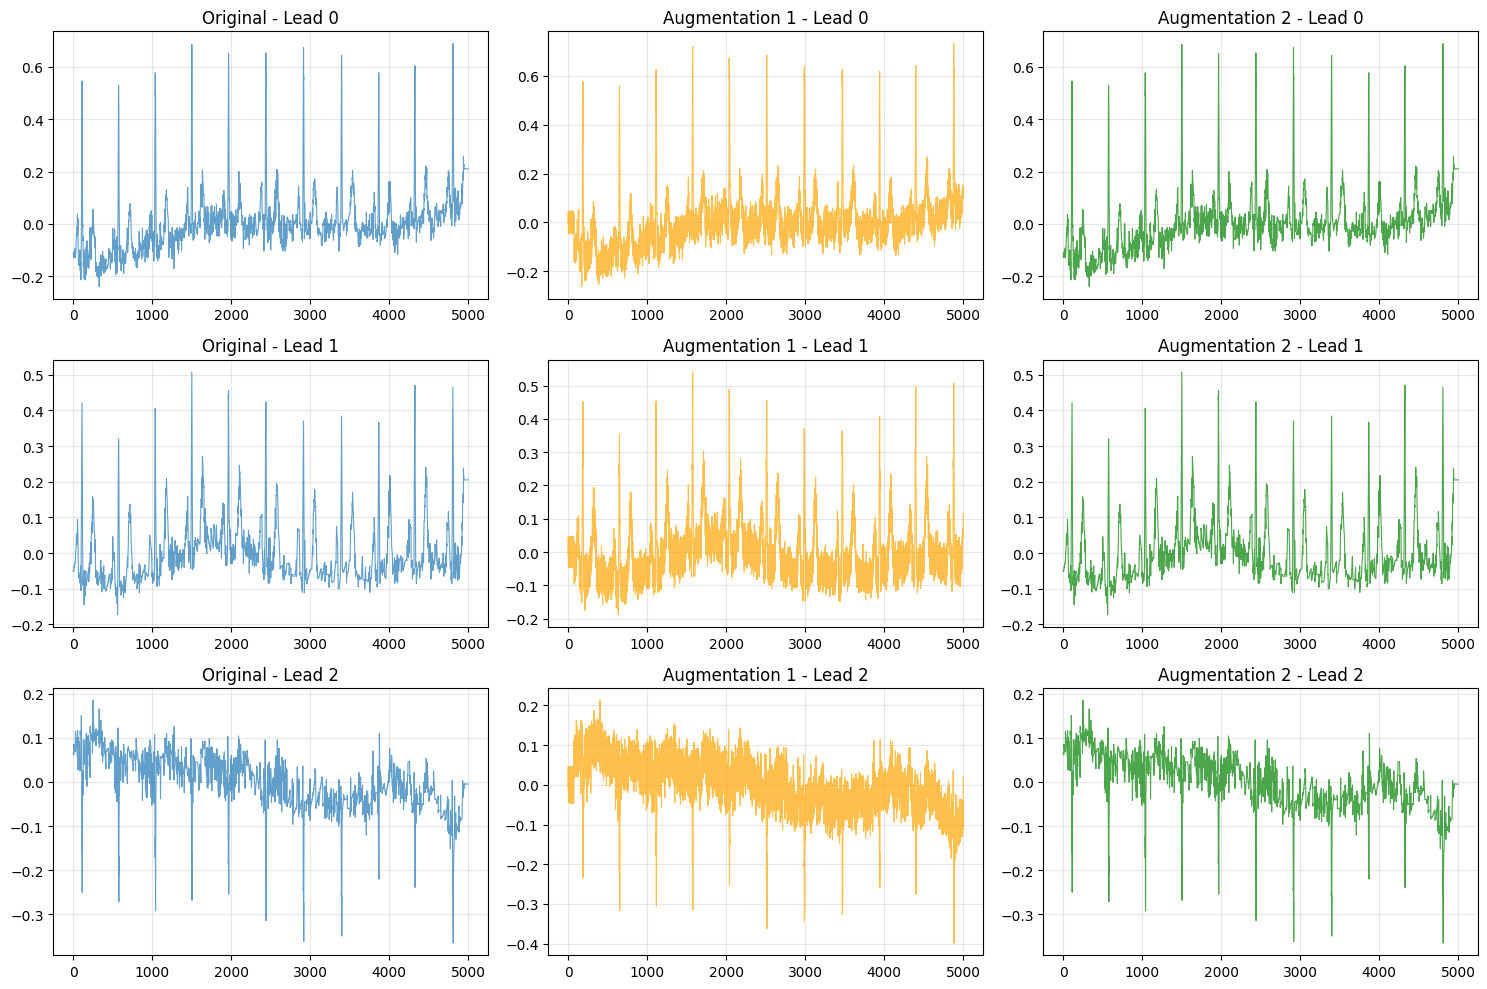


Signal Statistics:
  Original    - Mean: 0.0010, Std: 0.1091
  Aug1        - Mean: -0.0007, Std: 0.1126
  Aug2        - Mean: 0.0011, Std: 0.1091

Similarity Scores:
  Original vs Aug1: 0.0296
  Original vs Aug2: 0.9997
  Aug1 vs Aug2:     0.0300


/tmp/ipykernel_178513/3887079353.py:271: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([positive_sims, negative_sims], labels=['Positive Pairs', 'Negative Pairs'])


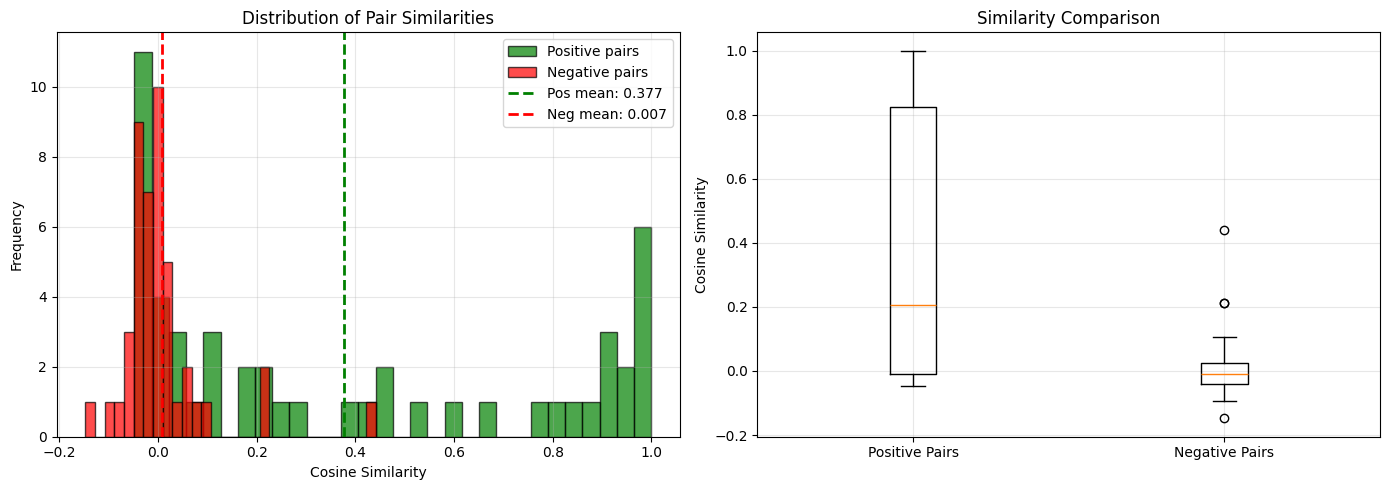


SANITIZATION SUMMARY
✓ Data quality:           PASS
✓ Positive pair mean:     0.3765
✓ Negative pair mean:     0.0069
✓ Separation margin:      0.3696

⚠️  Some checks failed. Review warnings above.


In [134]:
# Run comprehensive sanitization checks on the training dataset
sanitizer = DataSanitizer(
    dataset=train_dataset,
    augmenter1=augmenter1,
    augmenter2=augmenter2,
    n_samples=50  # Check 50 samples for statistical significance
)

# Run all checks
sanitizer.run_all_checks()

In [135]:
# Optional: Run individual checks if you want to focus on specific aspects

# Check just data quality
# sanitizer.check_data_quality()

# Check just augmentation diversity
# sanitizer.check_augmentation_diversity()

# Check just positive pairs
# positive_sims = sanitizer.check_positive_pairs()

# Check just negative pairs
# negative_sims = sanitizer.check_negative_pairs()

# Visualize specific sample (change index to see different samples)
# sanitizer.visualize_augmentations(sample_idx=5)

# Training Pipeline

## Checkpointing Manager

In [136]:
import os
from dataclasses import asdict
from pathlib import Path


class CheckpointManager:
    """
    Manages model checkpointing during training.
    
    Features:
    - Saves model, optimizer, and training state after each epoch
    - Keeps track of best model based on lowest loss
    - Maintains only the last N checkpoints to save disk space
    - Supports resuming training from saved checkpoints
    """
    
    def __init__(
        self,
        checkpoint_dir: str = "../models/checkpoints",
        keep_last_n: int = 3,
        save_best: bool = True
    ):
        self.checkpoint_dir = Path(checkpoint_dir)
        self.checkpoint_dir.mkdir(parents=True, exist_ok=True)
        self.keep_last_n = keep_last_n
        self.save_best = save_best
        self.best_loss = float('inf')
        
    def save_checkpoint(
        self,
        model,
        optimizer,
        epoch: int,
        loss: float,
        config: ECGModelConfig,
        additional_info: dict = None
    ):
        """Save checkpoint with model state, optimizer state, and metadata."""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'config': asdict(config),
        }
        
        if additional_info:
            checkpoint.update(additional_info)
        
        # Save regular epoch checkpoint
        checkpoint_path = self.checkpoint_dir / f"checkpoint_epoch_{epoch}.pt"
        torch.save(checkpoint, checkpoint_path)
        print(f"Saved checkpoint: {checkpoint_path}")
        
        # Save best model if this is the lowest loss
        if self.save_best and loss < self.best_loss:
            self.best_loss = loss
            best_path = self.checkpoint_dir / "best_model.pt"
            torch.save(checkpoint, best_path)
            print(f"New best model saved with loss: {loss:.4f}")
        
        # Save latest checkpoint (for easy resume)
        latest_path = self.checkpoint_dir / "latest.pt"
        torch.save(checkpoint, latest_path)
        
        # Clean up old checkpoints
        self._cleanup_old_checkpoints()
    
    def _cleanup_old_checkpoints(self):
        """Keep only the last N checkpoints to save disk space."""
        checkpoints = sorted(
            self.checkpoint_dir.glob("checkpoint_epoch_*.pt"),
            key=lambda p: int(p.stem.split('_')[-1])
        )
        
        # Remove old checkpoints beyond keep_last_n
        if len(checkpoints) > self.keep_last_n:
            for old_checkpoint in checkpoints[:-self.keep_last_n]:
                old_checkpoint.unlink()
                print(f"Removed old checkpoint: {old_checkpoint.name}")
    
    def load_checkpoint(self, checkpoint_path: str, model, optimizer=None, map_location=None):
        """
        Load checkpoint and restore model and optimizer states.
        
        Returns:
            Dictionary with epoch, loss, and config information
        """
        checkpoint = torch.load(checkpoint_path, map_location=map_location)
        model.load_state_dict(checkpoint['model_state_dict'])
        
        if optimizer and 'optimizer_state_dict' in checkpoint:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
        print(f"Loaded checkpoint from epoch {checkpoint['epoch']} with loss {checkpoint['loss']:.4f}")
        return checkpoint
    
    def get_latest_checkpoint(self):
        """Get path to the latest checkpoint if it exists."""
        latest_path = self.checkpoint_dir / "latest.pt"
        return str(latest_path) if latest_path.exists() else None

## Defining Optimizer, Loss, and Training Loop

In [137]:
from pytorch_metric_learning.losses import NTXentLoss

model = ECGEncoder(ECGModelConfig())
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
loss_fn = NTXentLoss(temperature=0.5)

In [138]:
import time
from typing import Optional

from tqdm import tqdm


def train(
    model,
    dataset,
    optimizer,
    loss_fn,
    config: ECGModelConfig,
    batch_size=64,
    epochs=1,
    checkpoint_manager: CheckpointManager = None,
    resume_from: str = None,
    device: Optional[torch.device] = None,
    val_dataset = None
):
    """
    Train the ECG encoder with contrastive learning.
    
    Args:
        model: ECGEncoder model
        dataset: ECGContrastiveTrainDataset
        optimizer: Optimizer (e.g., Adam)
        loss_fn: Loss function (e.g., NTXentLoss)
        config: Model configuration
        batch_size: Batch size for training
        epochs: Number of epochs to train
        checkpoint_manager: CheckpointManager instance for saving checkpoints
        resume_from: Path to checkpoint to resume training from
        device: Torch device to run training on (auto-selected if None)
        val_dataset: Optional validation dataset for evaluation after each epoch
    """
    if device is None:
        if torch.cuda.is_available():
            device = torch.device("cuda")
        elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
            device = torch.device("mps")
        else:
            device = torch.device("cpu")
    
    model.to(device)
    start_epoch = 0
    loss_history = []
    val_loss_history = []
    
    # Resume from checkpoint if specified
    if resume_from:
        if checkpoint_manager is None:
            raise ValueError("resume_from requires a checkpoint_manager instance")
        checkpoint = checkpoint_manager.load_checkpoint(
            resume_from, model, optimizer, map_location=device
        )
        start_epoch = checkpoint['epoch']
        loss_history = checkpoint.get('loss_history', [])
        val_loss_history = checkpoint.get('val_loss_history', [])
        print(f"Resuming training from epoch {start_epoch + 1}")
    
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) if val_dataset else None
    
    training_start_time = time.time()

    for epoch in range(start_epoch, start_epoch + epochs):
        # Training phase
        model.train()
        epoch_start_time = time.time()
        total_loss = 0.0
        total_grad_norm = 0.0
        
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{start_epoch + epochs} [Train]")
        
        for batch_idx, (aug1, aug2) in enumerate(progress_bar):
            optimizer.zero_grad(set_to_none=True)
            aug1 = aug1.to(device, non_blocking=True)
            aug2 = aug2.to(device, non_blocking=True)

            _, proj1 = model(aug1)
            _, proj2 = model(aug2)

            embeddings = torch.cat((proj1, proj2), dim=0)
            indices = torch.arange(0, proj1.size(0), device=device)
            labels = torch.cat((indices, indices), dim=0)

            loss = loss_fn(embeddings, labels)
            loss.backward()
            
            # Calculate gradient norm
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=float('inf'))
            total_grad_norm += grad_norm.item()
            
            optimizer.step()
            total_loss += loss.item()
            
            # Update progress bar with real-time metrics
            progress_bar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'grad_norm': f'{grad_norm.item():.2f}'
            })

        # Calculate training epoch metrics
        avg_loss = total_loss / len(dataloader)
        avg_grad_norm = total_grad_norm / len(dataloader) if len(dataloader) else 0.0
        epoch_time = time.time() - epoch_start_time
        total_time = time.time() - training_start_time
        
        loss_history.append(avg_loss)
        
        # Validation phase
        val_loss = None
        if val_dataloader:
            model.eval()
            val_total_loss = 0.0
            val_progress_bar = tqdm(val_dataloader, desc=f"Epoch {epoch + 1}/{start_epoch + epochs} [Val]")
            
            with torch.no_grad():
                for aug1, aug2 in val_progress_bar:
                    aug1 = aug1.to(device, non_blocking=True)
                    aug2 = aug2.to(device, non_blocking=True)

                    _, proj1 = model(aug1)
                    _, proj2 = model(aug2)

                    embeddings = torch.cat((proj1, proj2), dim=0)
                    indices = torch.arange(0, proj1.size(0), device=device)
                    labels = torch.cat((indices, indices), dim=0)

                    loss = loss_fn(embeddings, labels)
                    val_total_loss += loss.item()
                    
                    val_progress_bar.set_postfix({'val_loss': f'{loss.item():.4f}'})
            
            val_loss = val_total_loss / len(val_dataloader)
            val_loss_history.append(val_loss)
        
        # Print epoch summary
        summary = (f"Epoch [{epoch + 1}/{start_epoch + epochs}] "
                  f"Train Loss: {avg_loss:.4f} | "
                  f"Grad Norm: {avg_grad_norm:.2f} | ")
        if val_loss is not None:
            summary += f"Val Loss: {val_loss:.4f} | "
        summary += f"Time: {epoch_time:.1f}s | Total: {total_time:.1f}s"
        print(summary)
        
        # Save checkpoint after each epoch
        if checkpoint_manager:
            additional_info = {
                'loss_history': loss_history,
                'avg_grad_norm': avg_grad_norm,
                'epoch_time': epoch_time,
                'total_training_time': total_time
            }
            if val_loss is not None:
                additional_info['val_loss_history'] = val_loss_history
                additional_info['val_loss'] = val_loss
            
            checkpoint_manager.save_checkpoint(
                model=model,
                optimizer=optimizer,
                epoch=epoch + 1,
                loss=avg_loss,
                config=config,
                additional_info=additional_info
            )
    
    total_time = time.time() - training_start_time
    print(f"\nTraining completed in {total_time:.1f}s ({total_time/60:.1f} minutes)")
    
    result = {'loss_history': loss_history}
    if val_loss_history:
        result['val_loss_history'] = val_loss_history
    return result

# Baseline Model: 1D ResNet for ECG

This is a simpler baseline model based on ResNet architecture, commonly used in time-series classification papers:
- **Paper**: "Deep Residual Learning for Image Recognition" (He et al., 2015)
- **Adapted for 1D signals**: Used in many ECG papers including "Cardiologist-level arrhythmia detection" (Rajpurkar et al., 2017)
- **Architecture**: ResNet-18 style with 1D convolutions
- **Benefits**: Proven architecture, easier to train, fewer parameters

## Model Architecture

In [140]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass


@dataclass
class SimpleECGConfig:
    """Configuration for simple ResNet-based ECG encoder."""
    sequence_length: int = 5000
    num_channels: int = 12
    base_filters: int = 128
    projection_dim: int = 256
    dropout: float = 0.1
    dtype: torch.dtype = torch.float32


class BasicBlock1D(nn.Module):
    """Basic residual block for 1D convolutions."""
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None, dropout=0.1):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=7, 
                               stride=stride, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(dropout)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=7,
                               stride=1, padding=3, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out


class SimpleECGEncoder(nn.Module):
    """
    Simple ResNet-based encoder for ECG signals.
    
    Architecture inspired by:
    - He et al., "Deep Residual Learning for Image Recognition" (2015)
    - Rajpurkar et al., "Cardiologist-level arrhythmia detection" (2017)
    
    This is a much simpler baseline compared to the complex transformer architecture.
    """
    
    def __init__(self, config: SimpleECGConfig):
        super().__init__()
        self.config = config
        
        # Initial convolution to project channels
        self.conv1 = nn.Conv1d(config.num_channels, config.base_filters, 
                               kernel_size=15, stride=2, padding=7, bias=False)
        self.bn1 = nn.BatchNorm1d(config.base_filters)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        
        # Residual layers
        self.layer1 = self._make_layer(config.base_filters, config.base_filters, 2, stride=1)
        self.layer2 = self._make_layer(config.base_filters, config.base_filters * 2, 2, stride=2)
        self.layer3 = self._make_layer(config.base_filters * 2, config.base_filters * 4, 2, stride=2)
        self.layer4 = self._make_layer(config.base_filters * 4, config.base_filters * 8, 2, stride=2)
        
        # Global average pooling
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        
        # Projection head for contrastive learning
        self.projection_head = nn.Sequential(
            nn.Linear(config.base_filters * 8, config.base_filters * 4),
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.base_filters * 4, config.projection_dim)
        )
        
    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels),
            )
        
        layers = []
        layers.append(BasicBlock1D(in_channels, out_channels, stride, downsample, self.config.dropout))
        for _ in range(1, blocks):
            layers.append(BasicBlock1D(out_channels, out_channels, dropout=self.config.dropout))
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # x shape: (batch, time, channels) -> need (batch, channels, time)
        if x.dim() == 3:
            x = x.permute(0, 2, 1)
        
        # Initial conv
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        # Residual blocks
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        # Global pooling
        x = self.avgpool(x)
        representation = x.squeeze(-1)  # (batch, base_filters * 8)
        
        # Projection for contrastive learning
        projection = self.projection_head(representation)
        projection = F.normalize(projection, dim=-1)
        
        return representation, projection


# Test the model
print("Creating simple baseline model...")
simple_config = SimpleECGConfig()
simple_model = SimpleECGEncoder(simple_config)

# Count parameters
total_params = sum(p.numel() for p in simple_model.parameters())
trainable_params = sum(p.numel() for p in simple_model.parameters() if p.requires_grad)

print(f"\nSimple Model Summary:")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"\nCompare to complex model: {total_params / 1_000_000:.2f}M parameters")

# Test with sample input
sample_input = torch.randn(2, 5000, 12)  # (batch, time, channels)
repr_out, proj_out = simple_model(sample_input)
print(f"\nOutput shapes:")
print(f"  Representation: {repr_out.shape}")
print(f"  Projection: {proj_out.shape}")

Creating simple baseline model...

Simple Model Summary:
Total parameters: 35,563,520
Trainable parameters: 35,563,520

Compare to complex model: 35.56M parameters

Output shapes:
  Representation: torch.Size([2, 1024])
  Projection: torch.Size([2, 256])

Output shapes:
  Representation: torch.Size([2, 1024])
  Projection: torch.Size([2, 256])


In [141]:
# Initialize simple model with same training setup
simple_model = SimpleECGEncoder(SimpleECGConfig())
simple_optimizer = torch.optim.AdamW(simple_model.parameters(), lr=1e-4)  # Slightly higher LR for simpler model
simple_loss_fn = NTXentLoss(temperature=0.5)

# Train the baseline model
print("Training simple ResNet baseline model...")
print("=" * 80)

simple_history = train(
    model=simple_model,
    dataset=train_dataset,
    optimizer=simple_optimizer,
    loss_fn=simple_loss_fn,
    config=SimpleECGConfig(),
    batch_size=64,
    epochs=20,
    checkpoint_manager=CheckpointManager(
        checkpoint_dir="../models/checkpoints_simple",
        keep_last_n=2,
        save_best=True
    ),
    resume_from=None,
    val_dataset=val_dataset,
)

Training simple ResNet baseline model...


Epoch 1/20 [Val]: 100%|██████████| 6/6 [00:01<00:00,  3.89it/s, val_loss=2.6321]



Epoch [1/20] Train Loss: 3.6121 | Grad Norm: 2.22 | Val Loss: 3.1834 | Time: 21.5s | Total: 21.5s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_1.pt
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_1.pt
New best model saved with loss: 3.6121
New best model saved with loss: 3.6121
Removed old checkpoint: checkpoint_epoch_1.pt
Removed old checkpoint: checkpoint_epoch_1.pt


Epoch 2/20 [Val]: 100%|██████████| 6/6 [00:01<00:00,  4.11it/s, val_loss=2.7677]



Epoch [2/20] Train Loss: 3.2192 | Grad Norm: 1.78 | Val Loss: 3.1641 | Time: 21.5s | Total: 46.3s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_2.pt
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_2.pt
New best model saved with loss: 3.2192
New best model saved with loss: 3.2192
Removed old checkpoint: checkpoint_epoch_2.pt
Removed old checkpoint: checkpoint_epoch_2.pt


Epoch 3/20 [Val]: 100%|██████████| 6/6 [00:01<00:00,  4.00it/s, val_loss=2.5616]



Epoch [3/20] Train Loss: 3.1598 | Grad Norm: 1.70 | Val Loss: 3.0057 | Time: 22.0s | Total: 71.7s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_3.pt
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_3.pt
New best model saved with loss: 3.1598
New best model saved with loss: 3.1598
Removed old checkpoint: checkpoint_epoch_3.pt
Removed old checkpoint: checkpoint_epoch_3.pt


Epoch 4/20 [Val]: 100%|██████████| 6/6 [00:01<00:00,  3.76it/s, val_loss=2.5398]



Epoch [4/20] Train Loss: 3.1358 | Grad Norm: 1.59 | Val Loss: 3.0018 | Time: 21.6s | Total: 96.6s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_4.pt
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_4.pt
New best model saved with loss: 3.1358
New best model saved with loss: 3.1358
Removed old checkpoint: checkpoint_epoch_4.pt
Removed old checkpoint: checkpoint_epoch_4.pt


Epoch 5/20 [Val]: 100%|██████████| 6/6 [00:01<00:00,  4.07it/s, val_loss=2.5170]



Epoch [5/20] Train Loss: 3.1109 | Grad Norm: 1.42 | Val Loss: 2.9807 | Time: 21.6s | Total: 121.7s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_5.pt
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_5.pt
New best model saved with loss: 3.1109
New best model saved with loss: 3.1109
Removed old checkpoint: checkpoint_epoch_5.pt
Removed old checkpoint: checkpoint_epoch_5.pt


Epoch 6/20 [Val]: 100%|██████████| 6/6 [00:01<00:00,  3.75it/s, val_loss=2.4725]



Epoch [6/20] Train Loss: 3.0936 | Grad Norm: 1.33 | Val Loss: 2.9671 | Time: 21.7s | Total: 146.6s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_6.pt
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_6.pt
New best model saved with loss: 3.0936
New best model saved with loss: 3.0936
Removed old checkpoint: checkpoint_epoch_6.pt
Removed old checkpoint: checkpoint_epoch_6.pt


Epoch 7/20 [Val]: 100%|██████████| 6/6 [00:01<00:00,  3.75it/s, val_loss=2.6381]



Epoch [7/20] Train Loss: 3.0906 | Grad Norm: 1.33 | Val Loss: 3.0256 | Time: 21.9s | Total: 172.0s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_7.pt
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_7.pt
New best model saved with loss: 3.0906
New best model saved with loss: 3.0906
Removed old checkpoint: checkpoint_epoch_7.pt
Removed old checkpoint: checkpoint_epoch_7.pt


Epoch 8/20 [Val]: 100%|██████████| 6/6 [00:01<00:00,  3.68it/s, val_loss=2.4972]



Epoch [8/20] Train Loss: 3.0791 | Grad Norm: 1.19 | Val Loss: 2.9756 | Time: 21.7s | Total: 197.1s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_8.pt
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_8.pt
New best model saved with loss: 3.0791
New best model saved with loss: 3.0791
Removed old checkpoint: checkpoint_epoch_8.pt
Removed old checkpoint: checkpoint_epoch_8.pt


Epoch 9/20 [Val]: 100%|██████████| 6/6 [00:01<00:00,  3.98it/s, val_loss=2.5395]



Epoch [9/20] Train Loss: 3.0700 | Grad Norm: 1.21 | Val Loss: 2.9788 | Time: 22.0s | Total: 222.5s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_9.pt
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_9.pt
New best model saved with loss: 3.0700
New best model saved with loss: 3.0700
Removed old checkpoint: checkpoint_epoch_9.pt
Removed old checkpoint: checkpoint_epoch_9.pt


Epoch 10/20 [Val]: 100%|██████████| 6/6 [00:01<00:00,  3.92it/s, val_loss=2.4799]



Epoch [10/20] Train Loss: 3.0582 | Grad Norm: 1.11 | Val Loss: 2.9550 | Time: 21.6s | Total: 247.5s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_10.pt
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_10.pt
New best model saved with loss: 3.0582
New best model saved with loss: 3.0582
Removed old checkpoint: checkpoint_epoch_10.pt
Removed old checkpoint: checkpoint_epoch_10.pt


Epoch 11/20 [Val]: 100%|██████████| 6/6 [00:01<00:00,  3.63it/s, val_loss=2.5285]



Epoch [11/20] Train Loss: 3.0588 | Grad Norm: 1.14 | Val Loss: 2.9596 | Time: 21.7s | Total: 272.7s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_11.pt
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_11.pt
Removed old checkpoint: checkpoint_epoch_11.pt
Removed old checkpoint: checkpoint_epoch_11.pt


Epoch 12/20 [Val]: 100%|██████████| 6/6 [00:01<00:00,  3.56it/s, val_loss=2.4823]



Epoch [12/20] Train Loss: 3.0493 | Grad Norm: 1.04 | Val Loss: 2.9471 | Time: 21.7s | Total: 297.2s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_12.pt
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_12.pt
New best model saved with loss: 3.0493
New best model saved with loss: 3.0493
Removed old checkpoint: checkpoint_epoch_12.pt
Removed old checkpoint: checkpoint_epoch_12.pt


Epoch 13/20 [Val]: 100%|██████████| 6/6 [00:01<00:00,  3.97it/s, val_loss=2.4819]



Epoch [13/20] Train Loss: 3.0458 | Grad Norm: 1.02 | Val Loss: 2.9302 | Time: 21.7s | Total: 322.6s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_13.pt
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_13.pt
New best model saved with loss: 3.0458
New best model saved with loss: 3.0458
Removed old checkpoint: checkpoint_epoch_13.pt
Removed old checkpoint: checkpoint_epoch_13.pt


Epoch 14/20 [Val]: 100%|██████████| 6/6 [00:01<00:00,  3.85it/s, val_loss=2.4854]



Epoch [14/20] Train Loss: 3.0406 | Grad Norm: 1.04 | Val Loss: 2.9689 | Time: 21.8s | Total: 348.0s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_14.pt
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_14.pt
New best model saved with loss: 3.0406
New best model saved with loss: 3.0406
Removed old checkpoint: checkpoint_epoch_14.pt
Removed old checkpoint: checkpoint_epoch_14.pt


Epoch 15/20 [Val]: 100%|██████████| 6/6 [00:01<00:00,  3.93it/s, val_loss=2.4691]



Epoch [15/20] Train Loss: 3.0376 | Grad Norm: 0.99 | Val Loss: 2.9253 | Time: 21.7s | Total: 373.0s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_15.pt
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_15.pt
New best model saved with loss: 3.0376
New best model saved with loss: 3.0376
Removed old checkpoint: checkpoint_epoch_15.pt
Removed old checkpoint: checkpoint_epoch_15.pt


Epoch 16/20 [Val]: 100%|██████████| 6/6 [00:01<00:00,  3.90it/s, val_loss=2.4408]



Epoch [16/20] Train Loss: 3.0320 | Grad Norm: 0.98 | Val Loss: 2.9647 | Time: 21.8s | Total: 398.2s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_16.pt
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_16.pt
New best model saved with loss: 3.0320
New best model saved with loss: 3.0320
Removed old checkpoint: checkpoint_epoch_16.pt
Removed old checkpoint: checkpoint_epoch_16.pt


Epoch 17/20 [Val]: 100%|██████████| 6/6 [00:01<00:00,  4.00it/s, val_loss=2.4585]



Epoch [17/20] Train Loss: 3.0308 | Grad Norm: 0.95 | Val Loss: 2.9455 | Time: 21.7s | Total: 423.3s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_17.pt
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_17.pt
New best model saved with loss: 3.0308
New best model saved with loss: 3.0308
Removed old checkpoint: checkpoint_epoch_17.pt
Removed old checkpoint: checkpoint_epoch_17.pt


Epoch 18/20 [Val]: 100%|██████████| 6/6 [00:01<00:00,  3.70it/s, val_loss=2.4700]



Epoch [18/20] Train Loss: 3.0280 | Grad Norm: 0.96 | Val Loss: 2.9260 | Time: 21.9s | Total: 448.6s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_18.pt
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_18.pt
New best model saved with loss: 3.0280
New best model saved with loss: 3.0280
Removed old checkpoint: checkpoint_epoch_18.pt
Removed old checkpoint: checkpoint_epoch_18.pt


Epoch 19/20 [Val]: 100%|██████████| 6/6 [00:01<00:00,  3.72it/s, val_loss=2.4935]



Epoch [19/20] Train Loss: 3.0253 | Grad Norm: 0.94 | Val Loss: 2.9373 | Time: 21.8s | Total: 473.8s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_19.pt
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_19.pt
New best model saved with loss: 3.0253
New best model saved with loss: 3.0253


Epoch 20/20 [Val]: 100%|██████████| 6/6 [00:01<00:00,  3.96it/s, val_loss=2.4768]



Epoch [20/20] Train Loss: 3.0205 | Grad Norm: 0.93 | Val Loss: 2.9245 | Time: 21.7s | Total: 499.1s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_20.pt
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_20.pt
New best model saved with loss: 3.0205
New best model saved with loss: 3.0205

Training completed in 502.6s (8.4 minutes)

Training completed in 502.6s (8.4 minutes)


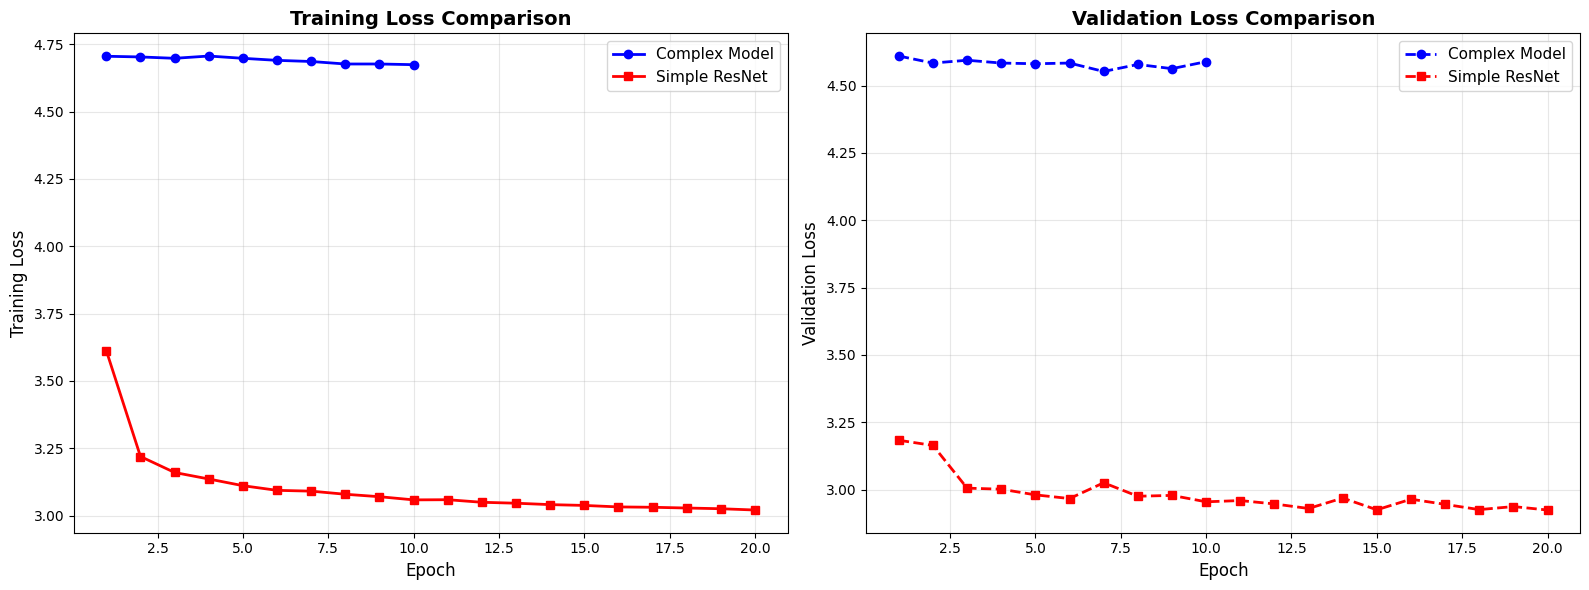


MODEL COMPARISON SUMMARY

Complex Transformer Model:
  Final Training Loss:   4.6740
  Final Validation Loss: 4.5885
  Best Validation Loss:  4.5521

Simple ResNet Baseline:
  Final Training Loss:   3.0205
  Final Validation Loss: 2.9245
  Best Validation Loss:  2.9245



In [142]:
# Compare training curves: Complex vs Simple model
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training loss comparison
axes[0].plot(range(1, len(history['loss_history']) + 1), 
             history['loss_history'], 'b-', label='Complex Model', linewidth=2, marker='o')
axes[0].plot(range(1, len(simple_history['loss_history']) + 1), 
             simple_history['loss_history'], 'r-', label='Simple ResNet', linewidth=2, marker='s')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Training Loss', fontsize=12)
axes[0].set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Validation loss comparison
if 'val_loss_history' in history and 'val_loss_history' in simple_history:
    axes[1].plot(range(1, len(history['val_loss_history']) + 1), 
                 history['val_loss_history'], 'b--', label='Complex Model', linewidth=2, marker='o')
    axes[1].plot(range(1, len(simple_history['val_loss_history']) + 1), 
                 simple_history['val_loss_history'], 'r--', label='Simple ResNet', linewidth=2, marker='s')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Validation Loss', fontsize=12)
    axes[1].set_title('Validation Loss Comparison', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print comparison statistics
print("\n" + "=" * 80)
print("MODEL COMPARISON SUMMARY")
print("=" * 80)
print("\nComplex Transformer Model:")
print(f"  Final Training Loss:   {history['loss_history'][-1]:.4f}")
if 'val_loss_history' in history:
    print(f"  Final Validation Loss: {history['val_loss_history'][-1]:.4f}")
    print(f"  Best Validation Loss:  {min(history['val_loss_history']):.4f}")

print("\nSimple ResNet Baseline:")
print(f"  Final Training Loss:   {simple_history['loss_history'][-1]:.4f}")
if 'val_loss_history' in simple_history:
    print(f"  Final Validation Loss: {simple_history['val_loss_history'][-1]:.4f}")
    print(f"  Best Validation Loss:  {min(simple_history['val_loss_history']):.4f}")

print("\n" + "=" * 80)

## Evaluate Simple Model Embeddings

Let's evaluate the quality of embeddings from the simple ResNet model and compare clustering metrics.

In [144]:
# Extract embeddings from simple model
print("Extracting embeddings from simple ResNet model...")
simple_embeddings, simple_labels = extract_embeddings(simple_model, test_loader)
print(f"Extracted {len(simple_embeddings)} embeddings with dimension {simple_embeddings.shape[1]}")

# Calculate clustering metrics for simple model
simple_metrics = calculate_clustering_metrics(simple_embeddings, simple_labels)
print("\n" + "=" * 80)
print("SIMPLE RESNET MODEL - CLUSTERING METRICS")
print_clustering_metrics(simple_metrics)

# Also show complex model metrics for comparison
print("\n" + "=" * 80)
print("COMPLEX TRANSFORMER MODEL - CLUSTERING METRICS (for comparison)")
print_clustering_metrics(metrics)

Extracting embeddings from simple ResNet model...
Extracted 618 embeddings with dimension 1024

SIMPLE RESNET MODEL - CLUSTERING METRICS
CLUSTERING QUALITY METRICS
Number of samples: 618
Number of classes: 4

Metrics:
  Silhouette Score:        -0.0379
    (Range: [-1, 1], Higher is better)
    > 0.5: Strong separation
    > 0.3: Reasonable separation

  Davies-Bouldin Score:    7.3068
    (Range: [0, ∞], Lower is better)
    < 1.0: Good clustering

  Calinski-Harabasz Score: 13.13
    (Range: [0, ∞], Higher is better)

Class Distribution:
  MI                  :  243 samples ( 39.3%)
  HYP                 :  225 samples ( 36.4%)
  NORM                :   76 samples ( 12.3%)
  STTC                :   74 samples ( 12.0%)

COMPLEX TRANSFORMER MODEL - CLUSTERING METRICS (for comparison)
CLUSTERING QUALITY METRICS
Number of samples: 618
Number of classes: 4

Metrics:
  Silhouette Score:        -0.0154
    (Range: [-1, 1], Higher is better)
    > 0.5: Strong separation
    > 0.3: Reasonable


Generating PCA visualization for simple model...


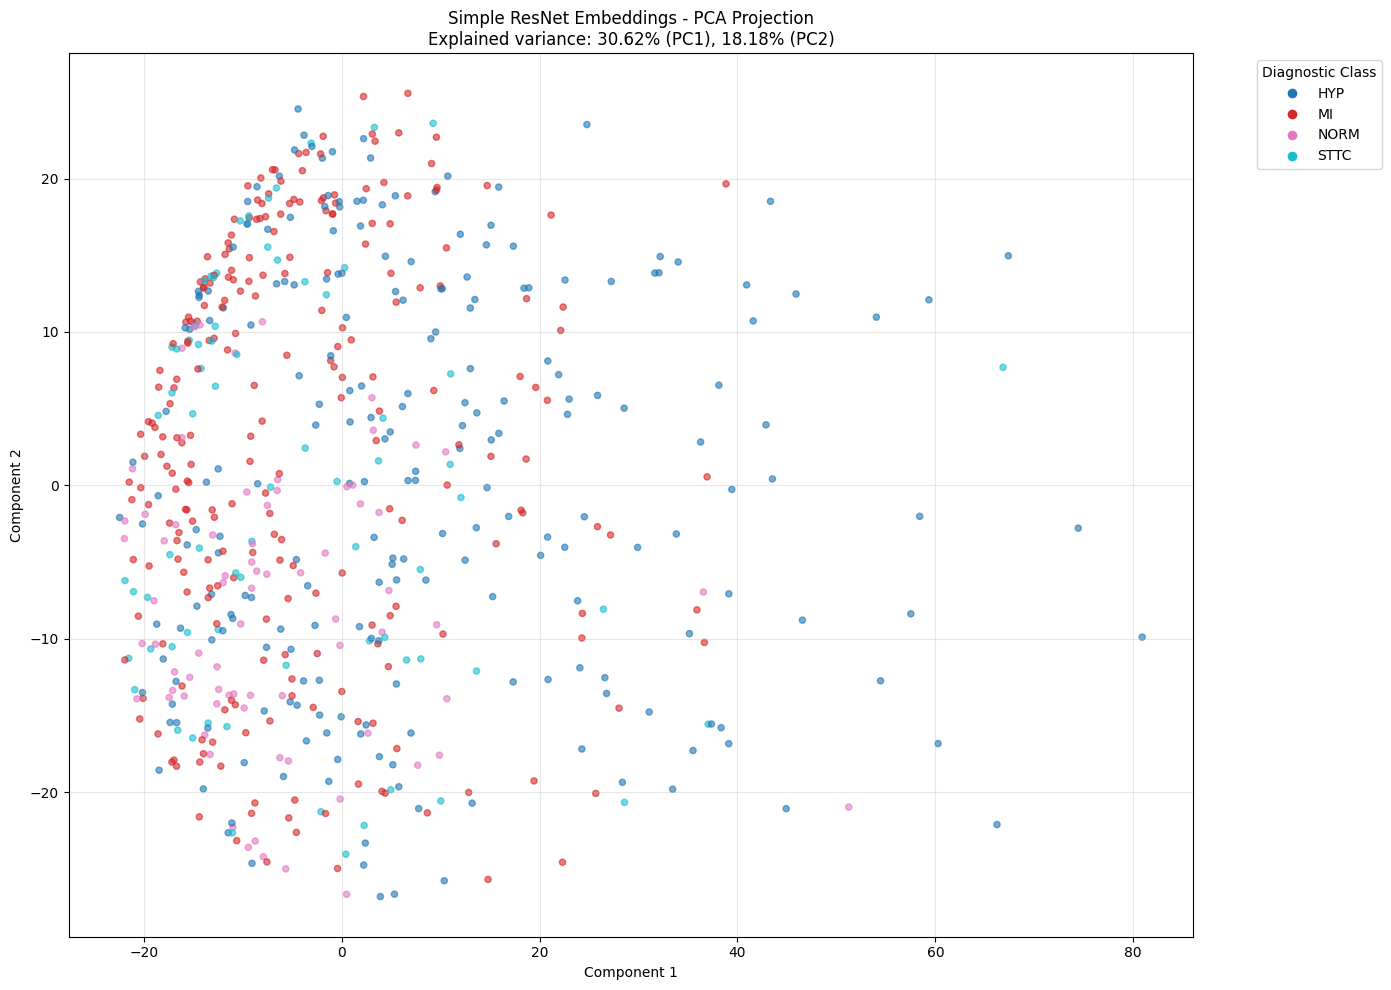

In [145]:
# Visualize simple model embeddings with PCA
print("\nGenerating PCA visualization for simple model...")
simple_embeddings_2d_pca, _ = plot_embeddings_2d(
    simple_embeddings, 
    simple_labels, 
    method='pca', 
    title='Simple ResNet Embeddings - PCA Projection',
    figsize=(14, 10)
)


Generating t-SNE visualization for simple model...


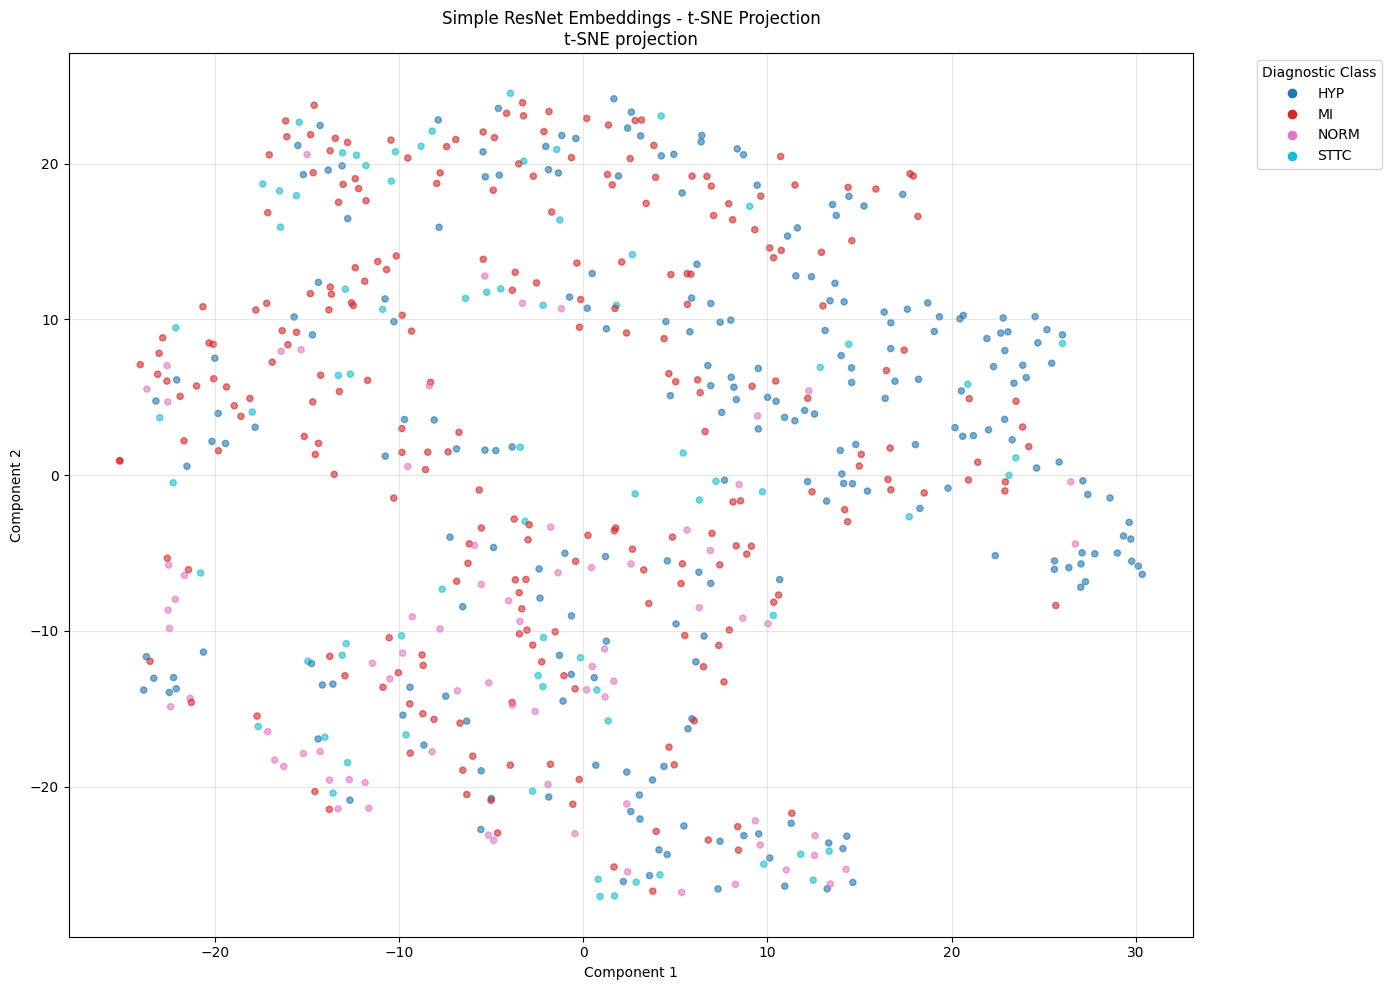

In [146]:
# Visualize simple model embeddings with t-SNE
print("\nGenerating t-SNE visualization for simple model...")
simple_embeddings_2d_tsne, _ = plot_embeddings_2d(
    simple_embeddings, 
    simple_labels, 
    method='tsne', 
    title='Simple ResNet Embeddings - t-SNE Projection',
    figsize=(14, 10)
)

## Final Comparison & Analysis

Let's create a comprehensive comparison between the two models to identify what's working and what's not.

In [143]:
# Comprehensive comparison table
import pandas as pd

comparison_data = {
    'Metric': [
        'Total Parameters',
        'Final Training Loss',
        'Final Validation Loss',
        'Best Validation Loss',
        'Silhouette Score',
        'Davies-Bouldin Score',
        'Calinski-Harabasz Score',
        'Embedding Dimension'
    ],
    'Complex Transformer': [
        f"{sum(p.numel() for p in model.parameters()):,}",
        f"{history['loss_history'][-1]:.4f}",
        f"{history.get('val_loss_history', [0])[-1]:.4f}" if 'val_loss_history' in history else "N/A",
        f"{min(history.get('val_loss_history', [0])):.4f}" if 'val_loss_history' in history else "N/A",
        f"{metrics['silhouette_score']:.4f}",
        f"{metrics['davies_bouldin_score']:.4f}",
        f"{metrics['calinski_harabasz_score']:.2f}",
        f"{embeddings.shape[1]}"
    ],
    'Simple ResNet': [
        f"{sum(p.numel() for p in simple_model.parameters()):,}",
        f"{simple_history['loss_history'][-1]:.4f}",
        f"{simple_history.get('val_loss_history', [0])[-1]:.4f}" if 'val_loss_history' in simple_history else "N/A",
        f"{min(simple_history.get('val_loss_history', [0])):.4f}" if 'val_loss_history' in simple_history else "N/A",
        f"{simple_metrics['silhouette_score']:.4f}",
        f"{simple_metrics['davies_bouldin_score']:.4f}",
        f"{simple_metrics['calinski_harabasz_score']:.2f}",
        f"{simple_embeddings.shape[1]}"
    ],
    'Better': [
        'Simple (fewer params)',
        'Lower is better',
        'Lower is better',
        'Lower is better',
        'Higher is better',
        'Lower is better',
        'Higher is better',
        'N/A'
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "=" * 100)
print("COMPREHENSIVE MODEL COMPARISON")
print("=" * 100)
print(comparison_df.to_string(index=False))
print("=" * 100)

# Determine winner for each metric
print("\n📊 METRIC-BY-METRIC ANALYSIS:\n")

def compare_metric(name, complex_val, simple_val, higher_better=False):
    try:
        c = float(complex_val)
        s = float(simple_val)
        if higher_better:
            winner = "Simple ResNet" if s > c else "Complex Transformer"
            diff = ((s - c) / abs(c)) * 100
        else:
            winner = "Simple ResNet" if s < c else "Complex Transformer"
            diff = ((c - s) / abs(c)) * 100
        print(f"  {name:30s}: {winner:20s} (difference: {abs(diff):+.1f}%)")
    except:
        print(f"  {name:30s}: Unable to compare")

compare_metric("Training Loss", history['loss_history'][-1], simple_history['loss_history'][-1], False)
if 'val_loss_history' in history and 'val_loss_history' in simple_history:
    compare_metric("Validation Loss", history['val_loss_history'][-1], simple_history['val_loss_history'][-1], False)
compare_metric("Silhouette Score", metrics['silhouette_score'], simple_metrics['silhouette_score'], True)
compare_metric("Davies-Bouldin Score", metrics['davies_bouldin_score'], simple_metrics['davies_bouldin_score'], False)
compare_metric("Calinski-Harabasz Score", metrics['calinski_harabasz_score'], simple_metrics['calinski_harabasz_score'], True)

print("\n" + "=" * 100)


COMPREHENSIVE MODEL COMPARISON
                 Metric Complex Transformer Simple ResNet                Better
       Total Parameters             237,601    35,563,520 Simple (fewer params)
    Final Training Loss              4.6740        3.0205       Lower is better
  Final Validation Loss              4.5885        2.9245       Lower is better
   Best Validation Loss              4.5521        2.9245       Lower is better
       Silhouette Score             -0.0154       -0.0292      Higher is better
   Davies-Bouldin Score             13.6939        7.2548       Lower is better
Calinski-Harabasz Score                2.00         12.38      Higher is better
    Embedding Dimension                  44          1024                   N/A

📊 METRIC-BY-METRIC ANALYSIS:

  Training Loss                 : Simple ResNet        (difference: +35.4%)
  Validation Loss               : Simple ResNet        (difference: +36.3%)
  Silhouette Score              : Complex Transformer  (differenc

# Our Architecture

In [ ]:
import math
from dataclasses import dataclass
from typing import Tuple

import torch
import torch.nn.functional as F
from torch import nn


@dataclass
class ECGModelConfig:
    sequence_length: int = 5000
    num_channels: int = 12
    d_model: int = 44
    time_heads: int = 4
    channel_heads: int = 4
    time_layers: int = 4
    channel_layers: int = 4
    ff_multiplier: int = 4
    dropout: float = 0.35
    temperature: float = 0.5
    projection_dim: int = 45
    dtype: torch.dtype = torch.bfloat16


class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int, dtype: torch.dtype) -> None:
        super().__init__()
        position = torch.arange(0, max_len, dtype=dtype).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2, dtype=dtype) * (-math.log(10000.0) / d_model)
        )
        pe = torch.zeros(max_len, d_model, dtype=dtype)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe.unsqueeze(0))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self.pe[:, : x.size(1)]


class TimeTransformer(nn.Module):
    def __init__(self, config: ECGModelConfig) -> None:
        super().__init__()
        self.input_proj = nn.Linear(
            config.num_channels, config.d_model, dtype=config.dtype
        )
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=config.d_model,
            nhead=config.time_heads,
            dim_feedforward=config.d_model * config.ff_multiplier,
            dropout=config.dropout,
            batch_first=True,
            activation="relu",
            dtype=config.dtype,
        )
        self.encoder = nn.TransformerEncoder(
            encoder_layer, num_layers=config.time_layers
        )
        self.positional_encoding = SinusoidalPositionalEncoding(
            config.d_model, config.sequence_length, config.dtype
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if x.dtype != self.input_proj.weight.dtype:
            x = x.to(self.input_proj.weight.dtype)
        x = self.input_proj(x)
        x = self.positional_encoding(x)
        return self.encoder(x)


class ChannelTransformer(nn.Module):
    def __init__(self, config: ECGModelConfig) -> None:
        super().__init__()
        # Pool across time dimension first, then project to d_model
        self.pool = nn.AdaptiveAvgPool1d(512)
        self.channel_proj = nn.Linear(512, config.d_model, dtype=config.dtype)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=config.d_model,
            nhead=config.channel_heads,
            dim_feedforward=config.d_model * config.ff_multiplier,
            dropout=config.dropout,
            batch_first=True,
            activation="relu",
            dtype=config.dtype,
        )
        self.encoder = nn.TransformerEncoder(
            encoder_layer, num_layers=config.channel_layers
        )
        self.num_channels = config.num_channels
        self.d_model = config.d_model
        self.dtype = config.dtype

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if x.dtype != self.dtype:
            x = x.to(self.dtype)

        batch_size = x.size(0)
        x = x.permute(0, 2, 1)  # (batch, channels, time) - e.g., (B, 12, 5000)
        x = self.pool(x)  # (batch, channels, 512) - aggregate time for each channel
        x = self.channel_proj(x.permute(0, 1, 2))  # (batch, channels, d_model)
        
        return self.encoder(x)


class BidirectionalCrossAttention(nn.Module):
    def __init__(self, config: ECGModelConfig) -> None:
        super().__init__()
        self.time_to_channel = nn.MultiheadAttention(
            config.d_model, config.time_heads, batch_first=True, dtype=config.dtype
        )
        self.channel_to_time = nn.MultiheadAttention(
            config.d_model, config.channel_heads, batch_first=True, dtype=config.dtype
        )
        self.time_norm = nn.LayerNorm(config.d_model, dtype=config.dtype)
        self.channel_norm = nn.LayerNorm(config.d_model, dtype=config.dtype)

    def forward(
        self, time_tokens: torch.Tensor, channel_tokens: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        time_cross, _ = self.time_to_channel(
            time_tokens, channel_tokens, channel_tokens
        )
        fused_time = self.time_norm(time_tokens + time_cross)
        channel_cross, _ = self.channel_to_time(
            channel_tokens, time_tokens, time_tokens
        )
        fused_channel = self.channel_norm(channel_tokens + channel_cross)
        return fused_time, fused_channel


class FusionHead(nn.Module):
    def __init__(self, config: ECGModelConfig) -> None:
        super().__init__()
        self.linear = nn.Linear(config.d_model * 2, config.d_model, dtype=config.dtype)
        self.norm = nn.LayerNorm(config.d_model, dtype=config.dtype)
        self.activation = nn.ReLU()

    def forward(
        self, time_repr: torch.Tensor, channel_repr: torch.Tensor
    ) -> torch.Tensor:
        fused = torch.cat([time_repr, channel_repr], dim=-1)
        mapped = self.linear(fused)
        return self.activation(self.norm(mapped))


class ProjectionHead(nn.Module):
    def __init__(self, config: ECGModelConfig) -> None:
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.d_model, config.d_model, dtype=config.dtype),
            nn.ReLU(),
            nn.Linear(config.d_model, config.projection_dim, dtype=config.dtype),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return F.normalize(self.net(x), dim=-1)


class ECGEncoder(nn.Module):
    def __init__(self, config: ECGModelConfig) -> None:
        super().__init__()
        self.time_encoder = TimeTransformer(config)
        self.channel_encoder = ChannelTransformer(config)
        self.cross_attention = BidirectionalCrossAttention(config)
        self.fusion = FusionHead(config)
        self.projection = ProjectionHead(config)
        self.dtype = config.dtype
        self.to(dtype=config.dtype)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        if x.dtype != self.dtype:
            x = x.to(self.dtype)
        time_tokens = self.time_encoder(x)
        channel_tokens = self.channel_encoder(x)
        fused_time, fused_channel = self.cross_attention(time_tokens, channel_tokens)
        time_repr = fused_time.mean(dim=1)
        channel_repr = fused_channel.mean(dim=1)
        representation = self.fusion(time_repr, channel_repr)
        projection = self.projection(representation)
        return representation, projection

In [ ]:
from typing import Tuple


def summarize_encoder_params(model) -> Tuple[int, int]:
    """
    Print a concise summary of the encoder's parameters and return (total, trainable).
    Uses existing `ecg_encoder`, `encoder_config`, `total_params`, `trainable_params` if available.
    """
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Model: {model.__class__.__name__}")
    print(f"Total params:     {total:,}")
    print(f"Trainable params: {trainable:,}\n")

    print("Per top-level module parameter counts:")
    for name, module in model.named_children():
        mod_total = sum(p.numel() for p in module.parameters())
        mod_train = sum(p.numel() for p in module.parameters() if p.requires_grad)
        print(f"  {name:20s} | total: {mod_total:10,} | trainable: {mod_train:10,}")

    print("\nParameter shapes (name, shape, trainable):")
    for name, p in model.named_parameters():
        print(f"  {name:60s} {tuple(p.shape)} {'trainable'}")

    return total, trainable


ecg_encoder = ECGEncoder(ECGModelConfig())

# Use the existing ecg_encoder variable in the notebook
total, trainable = summarize_encoder_params(ecg_encoder)

# If encoder_config and provided totals exist, print a quick consistency check
try:
    print("\nConsistency check with precomputed values (if present):")
    print(f"encoder_config: {encoder_config}")
    print(f"precomputed total_params:     {total_params:,}")
    print(f"precomputed trainable_params: {trainable_params:,}")
except NameError:
    pass

# Training

In [ ]:
import matplotlib.pyplot as plt

history = train(
    model=model,
    dataset=train_dataset,
    optimizer=optimizer,
    loss_fn=loss_fn,
    config=ECGModelConfig(),
    batch_size=64,
    epochs=10,
    checkpoint_manager=CheckpointManager(
        checkpoint_dir="../models/checkpoints",
        keep_last_n=2,
        save_best=True
    ),
    resume_from=None,
    val_dataset=val_dataset,
)


plt.figure(figsize=(10, 6))
epochs_range = range(1, len(history['loss_history']) + 1)
plt.plot(epochs_range, history['loss_history'], 'b-', label='Training Loss', linewidth=2)
if 'val_loss_history' in history and history['val_loss_history']:
    plt.plot(epochs_range, history['val_loss_history'], 'r-', label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss Over Time', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print final metrics
print(f"\nFinal Training Loss: {history['loss_history'][-1]:.4f}")
if 'val_loss_history' in history and history['val_loss_history']:
    print(f"Final Validation Loss: {history['val_loss_history'][-1]:.4f}")
    print(f"Best Validation Loss: {min(history['val_loss_history']):.4f} (Epoch {history['val_loss_history'].index(min(history['val_loss_history'])) + 1})")

# Evaluation
We will plot the test-set in 2-d using PCA and add the labels as the colors.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import numpy as np


def extract_embeddings(model, dataloader, device=None):
    """
    Extract embeddings and labels from the model for a given dataset.
    
    Args:
        model: Trained ECGEncoder
        dataloader: DataLoader with (signal, label) pairs
        device: Device to run inference on
        
    Returns:
        embeddings: numpy array of shape (n_samples, d_model)
        labels: list of labels
    """
    if device is None:
        device = next(model.parameters()).device
    
    model.eval()
    all_embeddings = []
    all_labels = []
    
    with torch.no_grad():
        for signals, labels in dataloader:
            signals = signals.to(device)
            representations, _ = model(signals)  # Use representations, not projections
            all_embeddings.append(representations.to(torch.float32).cpu().numpy())
            all_labels.extend(labels)
    
    embeddings = np.concatenate(all_embeddings, axis=0)
    return embeddings, all_labels


def plot_embeddings_2d(embeddings, labels, method='pca', title='ECG Embeddings Visualization', figsize=(12, 8)):
    """
    Plot embeddings in 2D using PCA or t-SNE.
    
    Args:
        embeddings: numpy array of shape (n_samples, d_model)
        labels: list of labels for each sample
        method: 'pca' or 'tsne'
        title: Plot title
        figsize: Figure size
    """
    # Reduce to 2D
    if method == 'pca':
        reducer = PCA(n_components=2, random_state=42)
        embeddings_2d = reducer.fit_transform(embeddings)
        explained_var = reducer.explained_variance_ratio_
        subtitle = f'Explained variance: {explained_var[0]:.2%} (PC1), {explained_var[1]:.2%} (PC2)'
    elif method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42, perplexity=30)
        embeddings_2d = reducer.fit_transform(embeddings)
        subtitle = 't-SNE projection'
    else:
        raise ValueError("method must be 'pca' or 'tsne'")
    
    # Create color map for labels
    unique_labels = sorted(list(set(labels)))
    label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
    colors = [label_to_idx[label] for label in labels]
    
    # Plot
    fig, ax = plt.subplots(figsize=figsize)
    scatter = ax.scatter(
        embeddings_2d[:, 0], 
        embeddings_2d[:, 1], 
        c=colors, 
        cmap='tab10', 
        alpha=0.6,
        s=20
    )
    
    # Add legend
    handles = [plt.Line2D([0], [0], marker='o', color='w', 
                          markerfacecolor=scatter.cmap(scatter.norm(label_to_idx[label])), 
                          markersize=8, label=label) 
               for label in unique_labels]
    ax.legend(handles=handles, title='Diagnostic Class', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_title(f'{title}\n{subtitle}')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return embeddings_2d, unique_labels


def calculate_clustering_metrics(embeddings, labels):
    """
    Calculate clustering quality metrics.
    
    Args:
        embeddings: numpy array of shape (n_samples, d_model)
        labels: list of labels
        
    Returns:
        Dictionary with clustering metrics
    """
    # Convert labels to numerical format
    unique_labels = sorted(list(set(labels)))
    label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
    numerical_labels = np.array([label_to_idx[label] for label in labels])
    
    # Calculate metrics
    metrics = {
        'silhouette_score': silhouette_score(embeddings, numerical_labels),
        'davies_bouldin_score': davies_bouldin_score(embeddings, numerical_labels),
        'calinski_harabasz_score': calinski_harabasz_score(embeddings, numerical_labels),
        'n_samples': len(labels),
        'n_classes': len(unique_labels),
        'class_distribution': {label: list(labels).count(label) for label in unique_labels}
    }
    
    return metrics


def print_clustering_metrics(metrics):
    """Pretty print clustering metrics."""
    print("=" * 60)
    print("CLUSTERING QUALITY METRICS")
    print("=" * 60)
    print(f"Number of samples: {metrics['n_samples']}")
    print(f"Number of classes: {metrics['n_classes']}")
    print()
    print("Metrics:")
    print(f"  Silhouette Score:        {metrics['silhouette_score']:.4f}")
    print(f"    (Range: [-1, 1], Higher is better)")
    print(f"    > 0.5: Strong separation")
    print(f"    > 0.3: Reasonable separation")
    print()
    print(f"  Davies-Bouldin Score:    {metrics['davies_bouldin_score']:.4f}")
    print(f"    (Range: [0, ∞], Lower is better)")
    print(f"    < 1.0: Good clustering")
    print()
    print(f"  Calinski-Harabasz Score: {metrics['calinski_harabasz_score']:.2f}")
    print(f"    (Range: [0, ∞], Higher is better)")
    print()
    print("Class Distribution:")
    for label, count in sorted(metrics['class_distribution'].items(), key=lambda x: x[1], reverse=True):
        percentage = (count / metrics['n_samples']) * 100
        print(f"  {label:20s}: {count:4d} samples ({percentage:5.1f}%)")
    print("=" * 60)

In [ ]:
# Extract embeddings from the test set
print("Extracting embeddings from test set...")

test_dataset = ECGDataset(
    X=X_train,
    y=y_train,
)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
embeddings, labels = extract_embeddings(model, test_loader)
print(f"Extracted {len(embeddings)} embeddings with dimension {embeddings.shape[1]}")
print(f"Found {len(set(labels))} unique classes: {sorted(set(labels))}")

In [ ]:
# Calculate and print clustering metrics
metrics = calculate_clustering_metrics(embeddings, labels)
print_clustering_metrics(metrics)

In [ ]:
# Visualize embeddings with PCA
print("\nGenerating PCA visualization...")
embeddings_2d_pca, unique_labels = plot_embeddings_2d(
    embeddings, 
    labels, 
    method='pca', 
    title='ECG Embeddings - PCA Projection',
    figsize=(14, 10)
)

In [ ]:
# Visualize embeddings with t-SNE (optional, takes longer)
print("\nGenerating t-SNE visualization...")
embeddings_2d_tsne, _ = plot_embeddings_2d(
    embeddings, 
    labels, 
    method='tsne', 
    title='ECG Embeddings - t-SNE Projection',
    figsize=(14, 10)
)

# Downstream classification